In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import os
from tqdm import tqdm
from fuzzywuzzy import fuzz

C:\Users\delff\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#функция перевода секунд в вид ЧЧ:ММ:СС    
def tosec (ttt):
    ttt = ttt.split('.')[0]
    ttt = '00:' + ttt
    sec = int(ttt.split(':')[-3]) * 3600 + int(ttt.split(':')[-2]) * 60 +  int(ttt.split(':')[-1])
    return sec

In [3]:
#Функций поиска похожих названий по расстоянию Левенштейна   
def fuzz_mo(data, col):
    res = {}
    for med_ind, med_inst_1 in enumerate(data[col].unique()):
        # Проверяем, чтобы индекс не был последним.
        if (data[col].nunique()-1) != med_ind:
            # Запускаем цикл по проверке расстояния Левенштейна.
            for med_inst_2 in data[col].unique()[(med_ind+1):]:
                if fuzz.ratio(med_inst_1, med_inst_2) >= 85:
                    # Вывод данных при совпадении условий.
                    res[med_inst_1] = med_inst_2             
    return res

# Загрузка данных

Грузим и обрабатываем все xls файлы протоколов из папки

In [4]:
print('Рабочая папка проекта на локальном компьютере')
%cd d:/swim run bike/triathlon_race_stat/

all = 0
path = 'results/'
rawdt = pd.DataFrame([])

t = tqdm(os.listdir(path))

for ff in t:
    if ff.split('.')[1] == 'xls':
        dd = pd.read_excel(path + ff, skiprows=range(0,5))
        t.set_description(f'{ff[0:30]}')
        dd['date'] = ff.split('-')[0]
        dd['city'] = ff.split('-')[1]
        dd['dist'] = ff.split('-')[3][:-4]
        dd['dist'] = dd['dist'].replace('18', '1/8').replace('14', '1/4')
        
        dd['race'] = dd['date'] + ' ' + dd['city'] + ' ' + dd['dist']
        dd['year'] = dd['date'].str[0:4]
        
       
        l = len(dd)
        all = all + l
        race = dd[['date', 'year', 'city', 'dist', 'race', 'Номер',\
                   'Возраст', 'Город', 'Клуб',\
                   'Категория', 'Статус', 'Место', 'Место в категории',\
                   'Плавание', 'T1', 'Велогонка', 'T2', 'Результат']].copy()
        race = race.reset_index(drop = True)
        race['Место в категории'] = race['Место в категории'].fillna(0)
        race['Плавание'] = race['Плавание'].fillna('00:00')
        race['T1'] = race['T1'].fillna('00:00')
        race['Велогонка'] = race['Велогонка'].fillna('00:00')
        race['T2'] = race['T2'].fillna('00:00')
        race['Результат'] = race['Результат'].fillna('00:00')
        race['Статус'] = race['Статус'].fillna('OK')
        race['Клуб'] = race['Клуб'].fillna(' Нет клуба/No club')
        #race = race.dropna()
        
        race['Категория'] = race['Категория'].replace({
            'Элита мужчины' : 'М элита', 
            'Элита женщины' : 'Ж элита',
            'Elite.Male' : 'М элита',
            'Elite.Female' : 'Ж элита',
            'Parathlete.Female' : 'Ж паратлет',
            'Parathlete.Male' : 'М паратлет',
            'Чемпионат РБ по триатлону' : 'М элита',
        })
        
        race['city'] = race['city'].replace({
            'moscow' : 'Москва', 
            'spb' : 'Санкт Петербург',
            'samara' : 'Самара',
            'anapa' : 'Анапа',
            'ekb' : 'Екатеринбург',
            'minsk' : 'Минск',
            'gelendgik' : 'Геленджик',
            'zavidovo' : 'Завидово',
            'astana' : 'Астана',
            'lipetsk' : 'Липецк',
            'kazan' : 'Казань',
            'nizhniy_novgorod' : 'Нижний Новгород',
            'bryansk' : 'Брянск',
            'sochi' : 'Сочи',
            'almetevsk' : 'Альметьевск',
            'tyumen' : 'Тюмень',
            'cherepovec' : 'Череповец',
            'kaliningrad' : 'Калининград',
            'krasnogorsk' : 'Красногорск',
        })        

        
        
        race['sex'] = race['Категория'].str[0]
        race['s_swim'] = race['Плавание'].apply(lambda x: tosec(x))
        race['s_t1'] = race['T1'].apply(lambda x: tosec(x))
        race['s_bike'] = race['Велогонка'].apply(lambda x: tosec(x))
        race['s_t2'] = race['T2'].apply(lambda x: tosec(x))
        race['s_finish'] = race['Результат'].apply(lambda x: tosec(x))

        
        swinmax = race.query('Статус == "OK"')['s_swim'].max()
        race['Плавание'] = race.apply(lambda row: '00:00' if row['s_swim'] > swinmax else row['Плавание'], axis=1)
        t1max = race.query('Статус == "OK"')['s_t1'].max()
        race['T1'] = race.apply(lambda row: '00:00' if row['s_t1'] > t1max else row['T1'], axis=1)
        bikemax = race.query('Статус == "OK"')['s_bike'].max()
        race['Велогонка'] = race.apply(lambda row: '00:00' if row['s_bike'] > bikemax else row['Велогонка'], axis=1)
        t2max = race.query('Статус == "OK"')['s_t2'].max()
        race['T2'] = race.apply(lambda row: '00:00' if row['s_t2'] > t2max else row['T2'], axis=1)
        runmax = race.query('Статус == "OK"')['s_finish'].max()
        race['Результат'] = race.apply(lambda row: '00:00' if row['s_finish'] > runmax else row['Результат'], axis=1)        
        
        race['swim'] = race['s_swim']
        race['t1'] = race['s_t1'] - race['swim'] 
        race['bike'] = race['s_bike'] - race['s_t1']
        race['t2'] = race['s_t2'] - race['s_bike']
        race['run'] = race['s_finish'] - race['s_t2']

        race['swim_per'] = round(100 * race['swim'] / race['s_finish'], 0)
        race['bike_per'] = round(100 * race['bike'] / race['s_finish'], 0)
        race['run_per'] = round(100 * race['run'] / race['s_finish'], 0)
        race['t_per'] = round(100 * (race['t1'] + race['t2']) / race['s_finish'], 0)

        rawdt = pd.concat([rawdt, race])
   
print(f'ФСЕ. Всего загружено {len(rawdt)} строк из {len(t)} файлов!')             

Рабочая папка проекта на локальном компьютере
d:\swim run bike\triathlon_race_stat


20241004-sochi-results_ind-oly: 100%|████████████████████████████████████████████████| 126/126 [00:32<00:00,  3.93it/s]

ФСЕ. Всего загружено 56308 строк из 126 файлов!


# Преодобработка данных

In [5]:
rawdt.head(5)

,date,year,city,dist,race,Номер,Возраст,Город,Клуб,Категория,...,s_finish,swim,t1,bike,t2,run,swim_per,bike_per,run_per,t_per
0,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,110,23,г Рыбинск,Нет клуба/No club,Мужчины,...,3555,613,65,1788,44,1045,17.0,50.0,29.0,3.0
1,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,112,32,г Рыбинск,Нет клуба/No club,Мужчины,...,3559,606,69,1790,47,1047,17.0,50.0,29.0,3.0
2,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,75,39,NaN,Нет клуба/No club,Мужчины,...,3626,614,49,1849,49,1065,17.0,51.0,29.0,3.0
3,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,163,38,г Нижнекамск,Нет клуба/No club,Мужчины,...,3709,693,61,1851,47,1057,19.0,50.0,28.0,3.0
4,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,51,42,г Ижевск,Нет клуба/No club,Мужчины,...,3715,741,65,1855,39,1015,20.0,50.0,27.0,3.0


In [6]:
rawdt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56308 entries, 0 to 842
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               56308 non-null  object 
 1   year               56308 non-null  object 
 2   city               56308 non-null  object 
 3   dist               56308 non-null  object 
 4   race               56308 non-null  object 
 5   Номер              56308 non-null  int64  
 6   Возраст            56308 non-null  int64  
 7   Город              54927 non-null  object 
 8   Клуб               56308 non-null  object 
 9   Категория          56308 non-null  object 
 10  Статус             56308 non-null  object 
 11  Место              47315 non-null  float64
 12  Место в категории  56308 non-null  float64
 13  Плавание           56308 non-null  object 
 14  T1                 56308 non-null  object 
 15  Велогонка          56308 non-null  object 
 16  T2                 56308 non-

In [7]:
rawdt = rawdt.rename(columns = {'Номер' : 'number', 'Возраст' : 'age', 'Город' : 'from', 
            'Клуб' : 'club', 'Категория' : 'cat', 'Статус': 'status', 'Место' : 'place', 
            'Место в категории' : 'cat_place',  
            'Плавание' : 'dt_swim', 'T1' : 'dt_t1', 'Велогонка' : 'dt_bike', 'T2' : 'dt_t2', 'Результат' : 'dt_finish'})

In [8]:
#Дубликаты
rawdt.query('status == "OK"')[['number', 'age', 'place', 'swim', 'bike', 'run']].duplicated().sum()

0

In [9]:
rawdt = rawdt.reset_index(drop=True)

# Чистим "плохие" результаты

Слишком маленькое время этапа или слишком большой процент этапа - смотрим и удаляем

In [10]:
bad1 = rawdt.query('status == "OK" and (swim < 280 or bike < 600 or run < 600)').index
rawdt.query('status == "OK" and (swim < 280 or bike < 600 or run < 600)')[['race', 'dt_swim', 'dt_t1', 'dt_bike', 'dt_t2', 'dt_finish']]

,race,dt_swim,dt_t1,dt_bike,dt_t2,dt_finish
17548,20220408 moscow 1/8,01:11,01:11,01:04:51,01:04:51,01:20:23
17844,20220408 moscow 1/8,01:33,01:33,01:25:16,01:25:16,01:44:45
27379,20220903 samara 113,00:36,00:36,27:18,27:18,05:30:07
27431,20220903 samara 113,01:05,01:05,49:38,03:29:19,05:50:42
36208,20230721 ekb sprint,03:28,03:28,01:37:09,01:37:09,02:02:42
36545,20230730 minsk olympic,02:39,02:39,01:59:03,01:59:03,02:26:57
36610,20230730 minsk olympic,03:01,03:01,02:15:15,02:15:15,02:46:58
36612,20230730 minsk olympic,03:01,03:01,02:15:27,02:15:27,02:47:12
36791,20230730 minsk sprint,01:45,01:45,01:15:37,01:15:37,01:34:52
36852,20230730 minsk sprint,02:35,02:35,01:51:35,01:51:35,02:20:00


In [11]:
bad2 = rawdt.query('status == "OK" and (swim_per > 40 or bike_per > 70 or run_per > 70)').index
rawdt.query('status == "OK" and (swim_per > 40 or bike_per > 70 or run_per > 70)')[['race', 'dt_swim', 'dt_t1', 'dt_bike', 'dt_t2', 'dt_finish']]

,race,dt_swim,dt_t1,dt_bike,dt_t2,dt_finish
15278,20211009 sochi 226,12:41,12:41,10:03:44,10:03:44,12:21:20
17548,20220408 moscow 1/8,01:11,01:11,01:04:51,01:04:51,01:20:23
17844,20220408 moscow 1/8,01:33,01:33,01:25:16,01:25:16,01:44:45
22464,20220717 spb 113,05:46,05:46,04:39:25,04:39:25,05:43:30
23712,20220730 minsk 113,05:31,05:31,04:26:50,04:26:50,05:28:06
27379,20220903 samara 113,00:36,00:36,27:18,27:18,05:30:07
29790,20221008 sochi olympic,05:25,05:25,02:22:35,02:22:35,03:00:29
33763,20230702 astana 113,50:50,50:50,06:05:32,06:05:32,07:18:16
36208,20230721 ekb sprint,03:28,03:28,01:37:09,01:37:09,02:02:42
36545,20230730 minsk olympic,02:39,02:39,01:59:03,01:59:03,02:26:57


In [12]:
bad = set(bad1).union(bad2)
rawdt = rawdt.query('~index.isin(@bad)').reset_index(drop=True)
rawdt.head(5)

,date,year,city,dist,race,number,age,from,club,cat,...,s_finish,swim,t1,bike,t2,run,swim_per,bike_per,run_per,t_per
0,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,110,23,г Рыбинск,Нет клуба/No club,Мужчины,...,3555,613,65,1788,44,1045,17.0,50.0,29.0,3.0
1,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,112,32,г Рыбинск,Нет клуба/No club,Мужчины,...,3559,606,69,1790,47,1047,17.0,50.0,29.0,3.0
2,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,75,39,NaN,Нет клуба/No club,Мужчины,...,3626,614,49,1849,49,1065,17.0,51.0,29.0,3.0
3,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,163,38,г Нижнекамск,Нет клуба/No club,Мужчины,...,3709,693,61,1851,47,1057,19.0,50.0,28.0,3.0
4,20200808,2020,Альметьевск,sprint,20200808 almetevsk sprint,51,42,г Ижевск,Нет клуба/No club,Мужчины,...,3715,741,65,1855,39,1015,20.0,50.0,27.0,3.0


In [13]:
print(f'Удалено строк - {len(bad)}. Для дальнейшего анализа принимается {len(rawdt)} результатов')

Удалено строк - 19. Для дальнейшего анализа принимается 56289 результатов


## Минимальное / максимальное время прохождения этапов

Визуальный контроль аномалий для корретировки в исходных файлах протоколов

In [14]:
mins = rawdt.query('status == "OK"').groupby('dist').agg({
    'swim' : 'min', 't1' : 'min', 'bike' : 'min', 't2' : 'min', 'run' : 'min'})
for col in mins.columns:
    mins[col+'_dt'] = mins[col].apply(lambda x: f'{(x // 3600):02d}:{((x % 3600) // 60):02d}:{(x % 60):02d}')
mins.sort_values(by='bike')

,swim,t1,bike,t2,run,swim_dt,t1_dt,bike_dt,t2_dt,run_dt
dist,,,,,,,,,,
sprint,385,0,1375,0,778,00:06:25,00:00:00,00:22:55,00:00:00,00:12:58
1/8,288,0,1454,0,818,00:04:48,00:00:00,00:24:14,00:00:00,00:13:38
olympic,646,0,3023,0,1844,00:10:46,00:00:00,00:50:23,00:00:00,00:30:44
1/4,720,0,3522,0,1983,00:12:00,00:00:00,00:58:42,00:00:00,00:33:03
113,1101,0,7071,0,4148,00:18:21,00:00:00,01:57:51,00:00:00,01:09:08
226,2861,0,14659,0,9260,00:47:41,00:00:00,04:04:19,00:00:00,02:34:20


In [15]:
maxs = rawdt.query('status == "OK"').groupby('dist').agg({
    'swim' : 'max', 't1' : 'max', 'bike' : 'max', 't2' : 'max', 'run' : 'max'})
for col in maxs.columns:
    maxs[col+'_dt'] = maxs[col].apply(lambda x: f'{(x // 3600):02d}:{((x % 3600) // 60):02d}:{(x % 60):02d}')
maxs.sort_values(by='bike')

,swim,t1,bike,t2,run,swim_dt,t1_dt,bike_dt,t2_dt,run_dt
dist,,,,,,,,,,
sprint,2528,1084,4680,417,3752,00:42:08,00:18:04,01:18:00,00:06:57,01:02:32
1/8,1482,785,4703,543,4079,00:24:42,00:13:05,01:18:23,00:09:03,01:07:59
1/4,2660,1565,8286,745,6461,00:44:20,00:26:05,02:18:06,00:12:25,01:47:41
olympic,3967,3846,8791,957,6336,01:06:07,01:04:06,02:26:31,00:15:57,01:45:36
113,4198,1853,17288,2065,14867,01:09:58,00:30:53,04:48:08,00:34:25,04:07:47
226,8398,2580,31020,2254,32116,02:19:58,00:43:00,08:37:00,00:37:34,08:55:16


## Приводим клубы к единообразию

In [16]:
#колво уникальных ДО
rawdt['club'].nunique()

626

In [17]:
rawdt['club'] = rawdt['club'].str.strip().str.lower().str.replace('#', '').str.replace('"', '')

In [18]:
rawdt['club'].nunique()

616

In [19]:
dic = {'клуб' : 'club'}
while len(dic) > 0:
    dic = fuzz_mo(rawdt, 'club')
    #dic = fuzz_mo(rawdt['club'].value_counts()[rawdt['club'].value_counts() > 2].reset_index(), 'club')
    rawdt['club'] = rawdt['club'].replace(dic)
    print(len(dic))    

19
0


In [20]:
#колво уникальных ПОСЛЕ
rawdt['club'].nunique()

597

In [21]:
rawdt['club'] = rawdt['club'].replace({'нет клуба/no club' : '#Нет клуба/No club'})

## Приводим откуда к единообразию

In [22]:
#колво уникальных ДО
rawdt['from'].nunique()

2503

In [23]:
rawdt['from'] = rawdt['from'].str.strip().str.lower()\
    .str.replace('г ', '').str.replace('г. ', '').str.replace('г.', '')\
    .str.replace('д.', '').str.replace('c.', '').str.replace('п.', '').str.replace('о.', '')\
    .str.replace('.-', '-').str.replace(' - ', '-').str.strip()

In [24]:
rawdt['from'].nunique()

2185

In [25]:
dic = {'moscow' : 'Москва'}
while len(dic) > 0:
    dic = fuzz_mo(rawdt['from'].value_counts()[rawdt['from'].value_counts() > 2].reset_index(), 'from')
    rawdt['from'] = rawdt['from'].replace(dic)
    print(len(dic))      

43
1
0


In [26]:
#колво уникальных ПОСЛЕ
rawdt['from'].nunique()

2143

In [27]:
rawdt['from'] = rawdt['from'].replace({
    'moscow' : 'москва',
    'saint- petersburg' : 'санкт петербург',
    'минк' : 'минск',    
    }) 

# Выгрузка для Datalens

In [28]:
rawdt.to_csv('all_data.csv')

# Всякие красивые графики

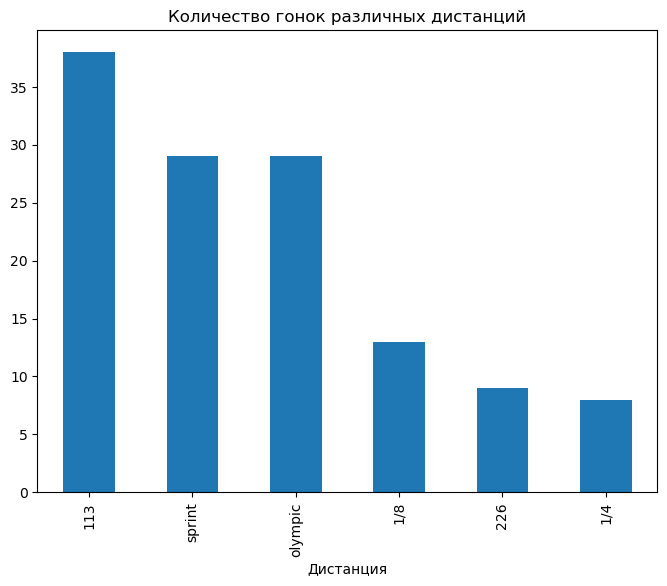

In [29]:
fig = plt.figure(figsize = (8, 6))
rawdt.groupby('dist')['race'].nunique().sort_values()[::-1].plot.bar()
plt.title('Количество гонок различных дистанций')
plt.xlabel('Дистанция')
plt.show()

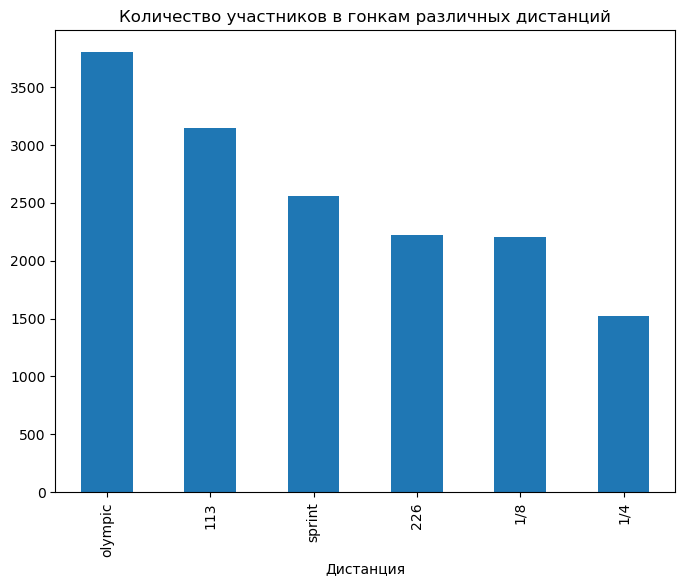

In [30]:
fig = plt.figure(figsize = (8, 6))
rawdt.groupby('dist')['number'].nunique().sort_values()[::-1].plot.bar()
plt.title('Количество участников в гонкам различных дистанций')
plt.xlabel('Дистанция')
plt.show()

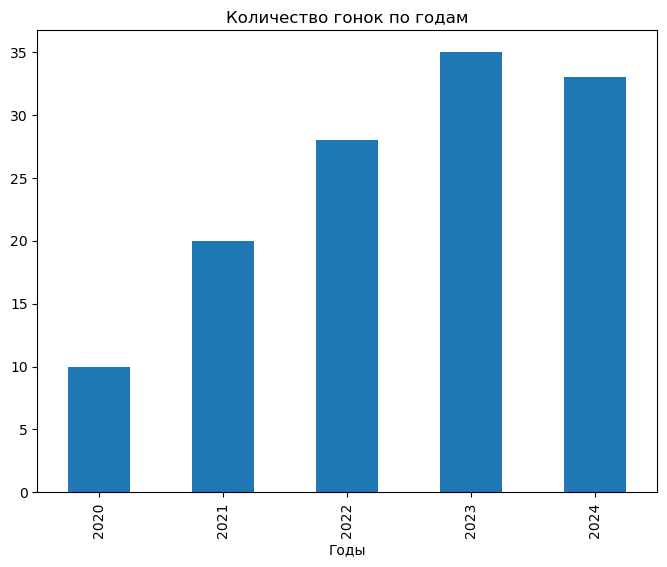

In [31]:
fig = plt.figure(figsize = (8, 6))
rawdt.groupby('year')['race'].nunique().plot.bar()
plt.title('Количество гонок по годам')
plt.xlabel('Годы')
plt.show()

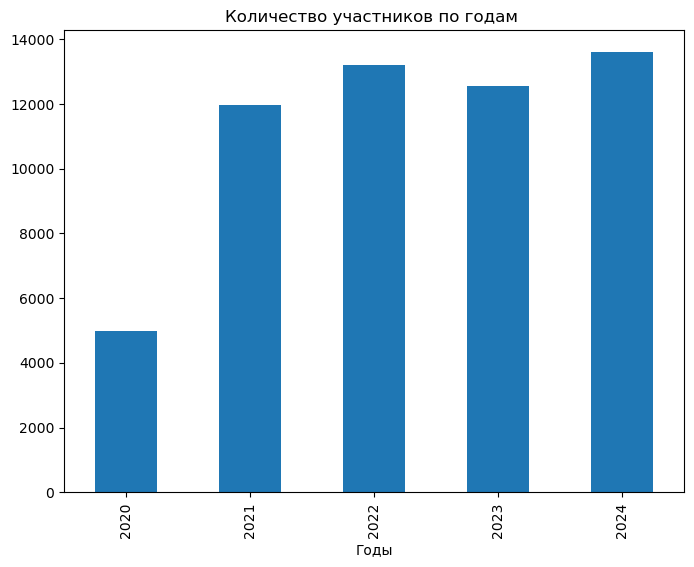

In [32]:
fig = plt.figure(figsize = (8, 6))
rawdt.groupby('year')['number'].count().plot.bar()
plt.title('Количество участников по годам ')
plt.xlabel('Годы')
plt.show()

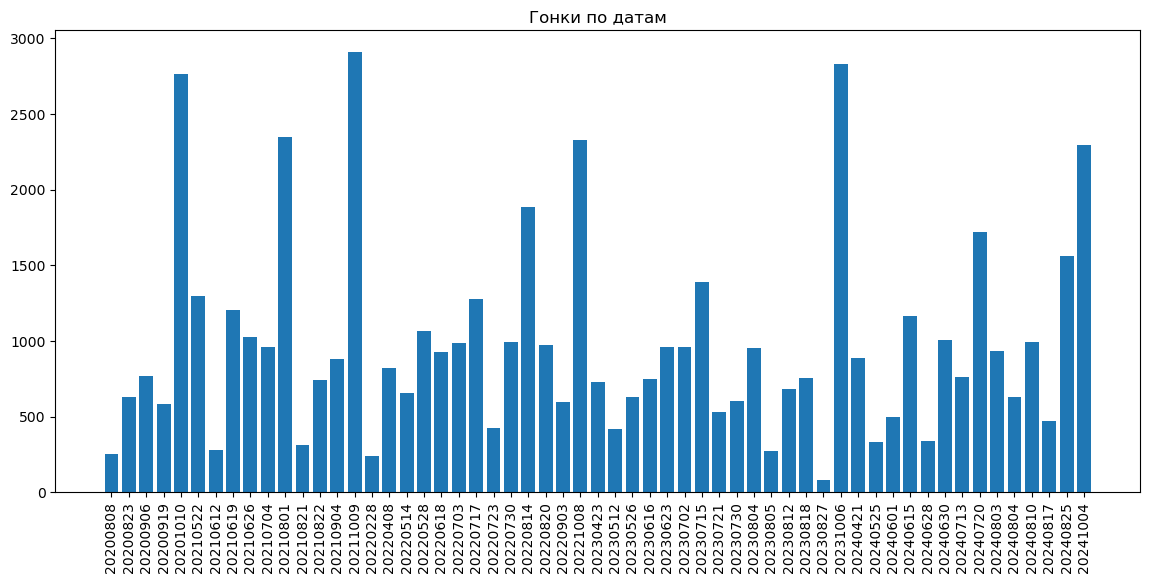

In [33]:
fig = plt.figure(figsize = (14, 6))
dd = rawdt.groupby('date')['number'].count()
plt.bar(height = dd.values, x = dd.index)
plt.xticks(rotation=90)
plt.title('Гонки по датам')
plt.show()

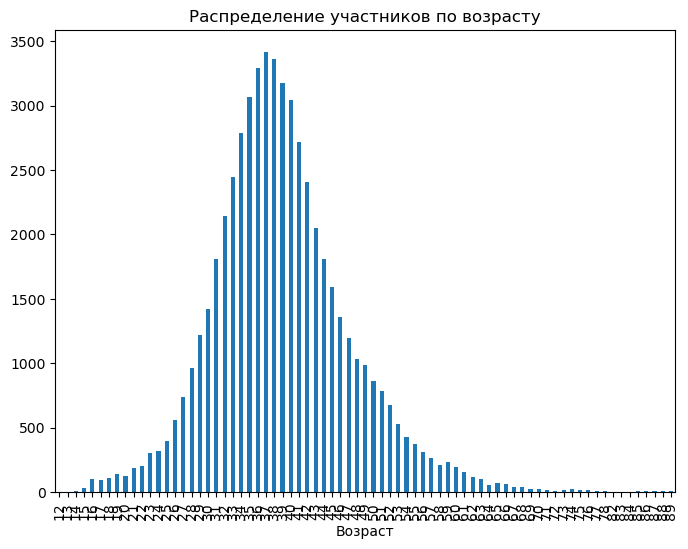

In [34]:
fig = plt.figure(figsize = (8, 6))
rawdt.groupby('age')['number'].count().plot.bar()
plt.title('Распределение участников по возрасту')
plt.xlabel('Возраст')
plt.show()

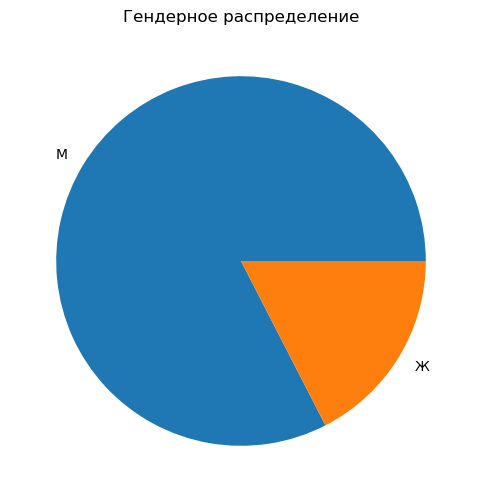

In [35]:
fig = plt.figure(figsize = (8, 6))
rawdt['sex'].value_counts().plot.pie()
plt.title('Гендерное распределение')
plt.ylabel('')
plt.show()

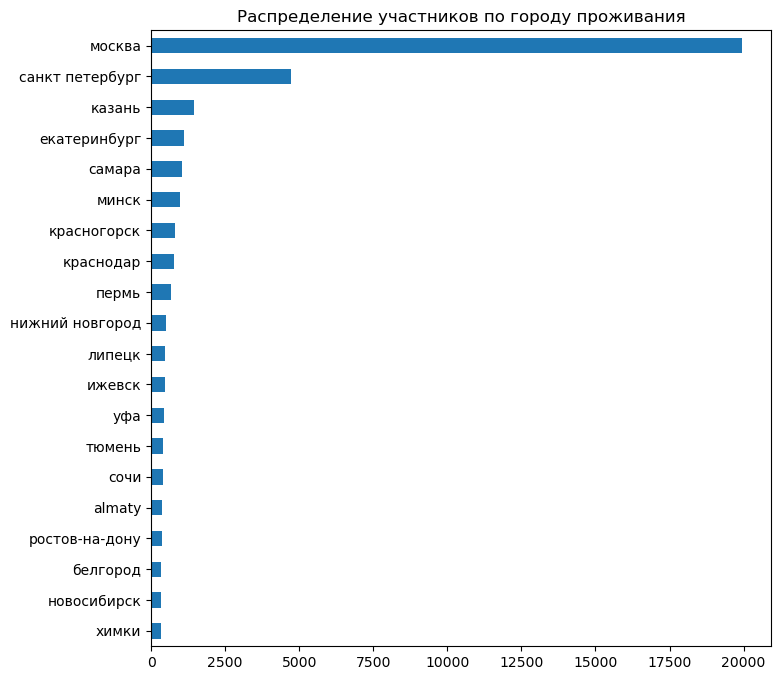

In [36]:
fig = plt.figure(figsize = (8, 8))
rawdt['from'].value_counts()[0:20][::-1].plot.barh()
plt.title('Распределение участников по городу проживания')
plt.ylabel('')
plt.show()

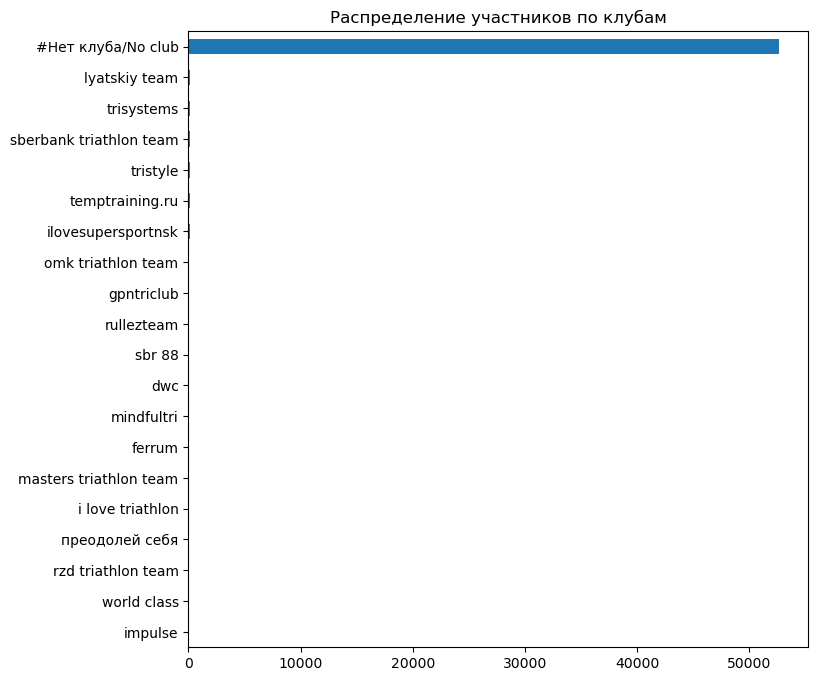

In [37]:
fig = plt.figure(figsize = (8, 8))
rawdt['club'].value_counts()[0:20][::-1].plot.barh()
plt.title('Распределение участников по клубам')
plt.ylabel('')
plt.show()

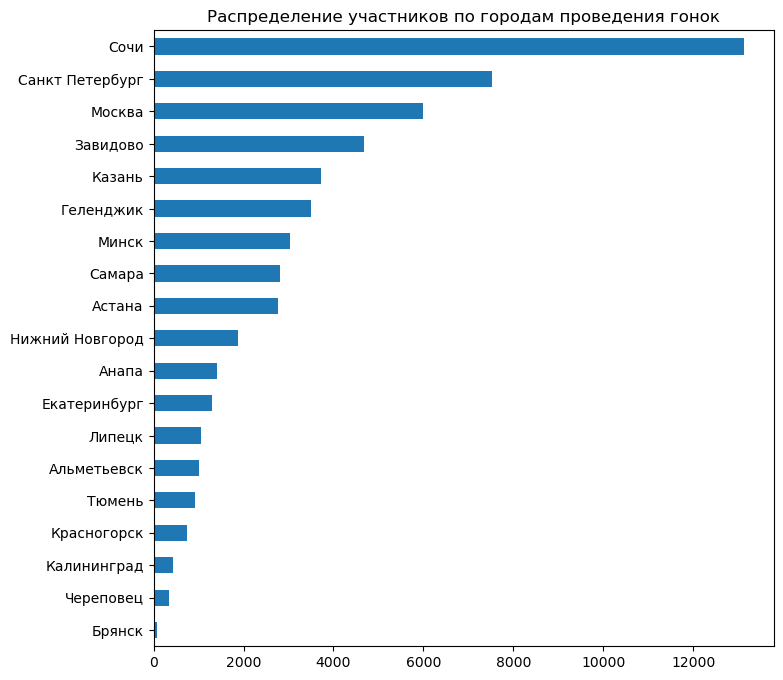

In [38]:
fig = plt.figure(figsize = (8, 8))
rawdt['city'].value_counts()[::-1].plot.barh()
plt.title('Распределение участников по городам проведения гонок')
plt.ylabel('')
plt.show()

In [39]:
users = rawdt.groupby(['race', 'status'], as_index=False)['number'].count()
users = users.pivot(index = 'race', columns = 'status', values = 'number')
users = users.fillna(0)

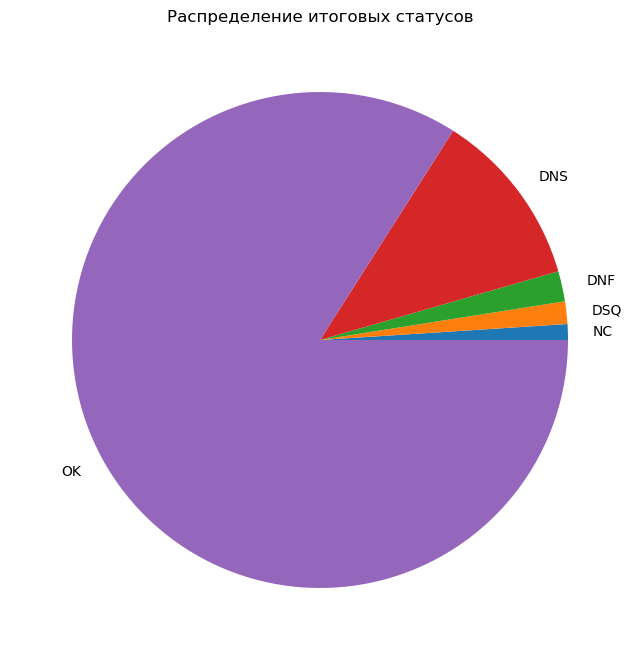

In [40]:
fig = plt.figure(figsize = (8, 10))
users.sum().sort_values().plot.pie()
plt.title('Распределение итоговых статусов')
plt.show()

In [41]:
users['all'] = users['OK'] + users['DSQ'] + users['DNS'] + users['DNF'] + users['NC']
users['start'] = users['all'] - users['DNS']
users['finish_pre'] = round(100 * users['OK'] / (users['all'] - users['DNS']), 2)

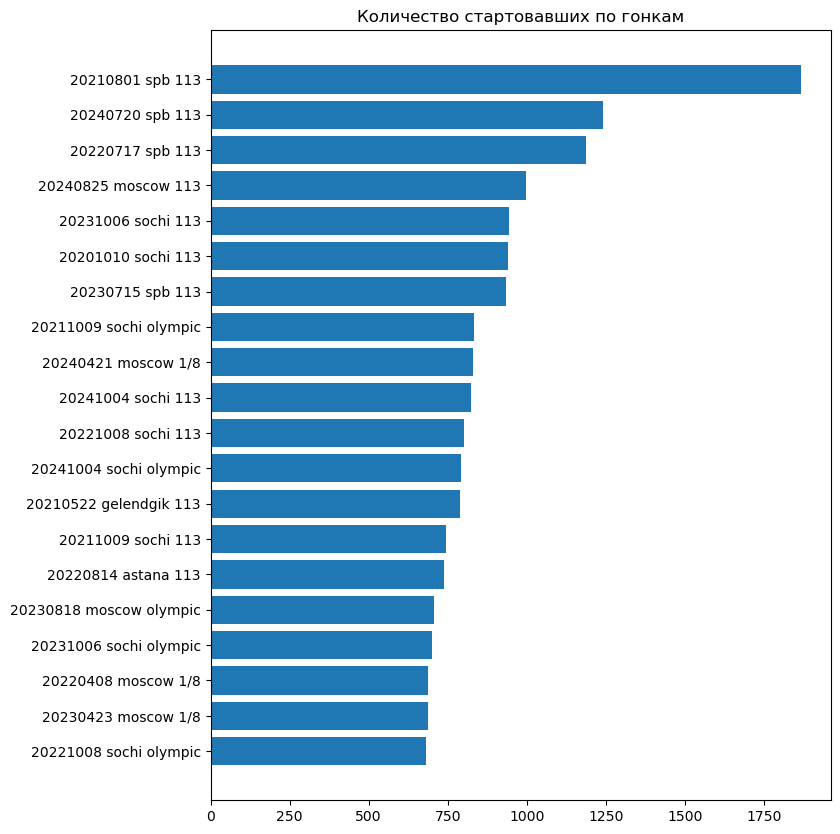

In [42]:
fig = plt.figure(figsize = (8, 10))
dd = users['start'].sort_values(ascending=False)[0:20][::-1]
plt.barh(width = dd.values, y = dd.index)
plt.title('Количество стартовавших по гонкам')
plt.show()

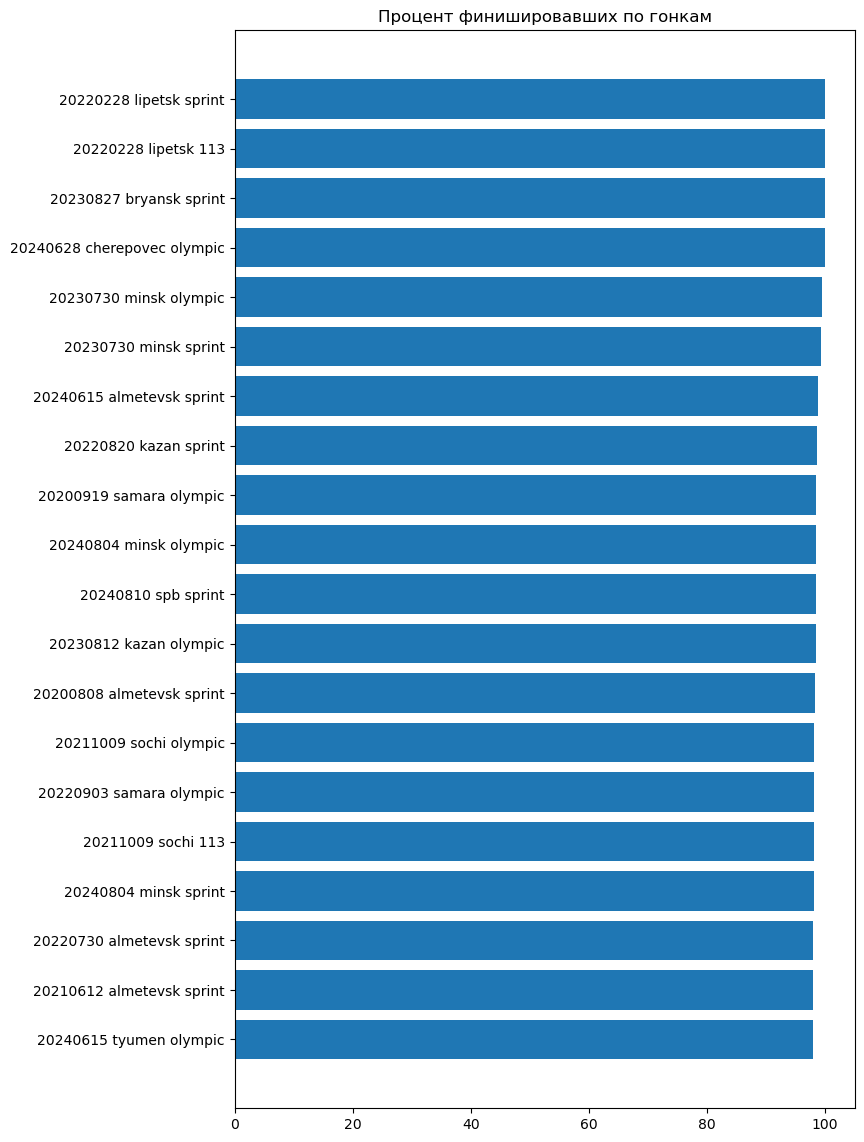

In [43]:
fig = plt.figure(figsize = (8, 14))
dd = users['finish_pre'].sort_values(ascending=False)[0:20][::-1]
plt.barh(width = dd.values, y = dd.index)
plt.title('Процент финишировавших по гонкам')
plt.show()

# Воронка сходов

In [44]:
dnf = rawdt.query('status == "DNF"').copy()
len_dnf = len(dnf)
len_dnf

1110

In [45]:
dnf[['dt_swim', 'dt_t1', 'dt_bike', 'dt_t2', 'dt_finish']].sample(10)

,dt_swim,dt_t1,dt_bike,dt_t2,dt_finish
48854,36:25,43:43,03:08:31,03:14:34,00:00
25815,00:00,00:00,00:00,00:00,00:00
34549,35:36,00:00,01:06:42,00:00,00:00
35490,42:35,48:20,03:05:10,03:07:53,00:00
34419,01:36:01,01:40:23,05:21:00,05:25:16,00:00
53384,38:05,41:01,02:57:01,03:00:27,00:00
42120,01:08:43,01:12:01,03:50:52,00:00,00:00
50942,41:02,44:51,01:47:54,01:50:42,00:00
5467,39:49,44:56,01:57:17,00:00,00:00
7193,38:51,43:21,03:20:51,03:25:11,00:00


In [46]:
print('Сошли на плавании', dnf.query('dt_swim == "00:00"')['number'].count())
print('Сошли на t1', dnf.query('dt_swim != "00:00" and dt_t1 == "00:00"')['number'].count())
print('Сошли на вело', dnf.query('dt_swim != "00:00" and dt_t1 != "00:00" and dt_bike == "00:00"')['number'].count())
print('Сошли на t2', dnf.query('dt_swim != "00:00" and dt_t1 != "00:00" and dt_bike != "00:00" and dt_t2 == "00:00"')['number'].count())
print('Сошли на беге', dnf.query('dt_swim != "00:00" and dt_t1 != "00:00" and dt_bike != "00:00" and dt_t2 != "00:00" and dt_finish == "00:00"')['number'].count())

Сошли на плавании 164
Сошли на t1 104
Сошли на вело 49
Сошли на t2 259
Сошли на беге 534


# Анализ времен этапов отдельно по половинкам

In [47]:
race = rawdt.query('status == "OK" and dist == "113"').copy()

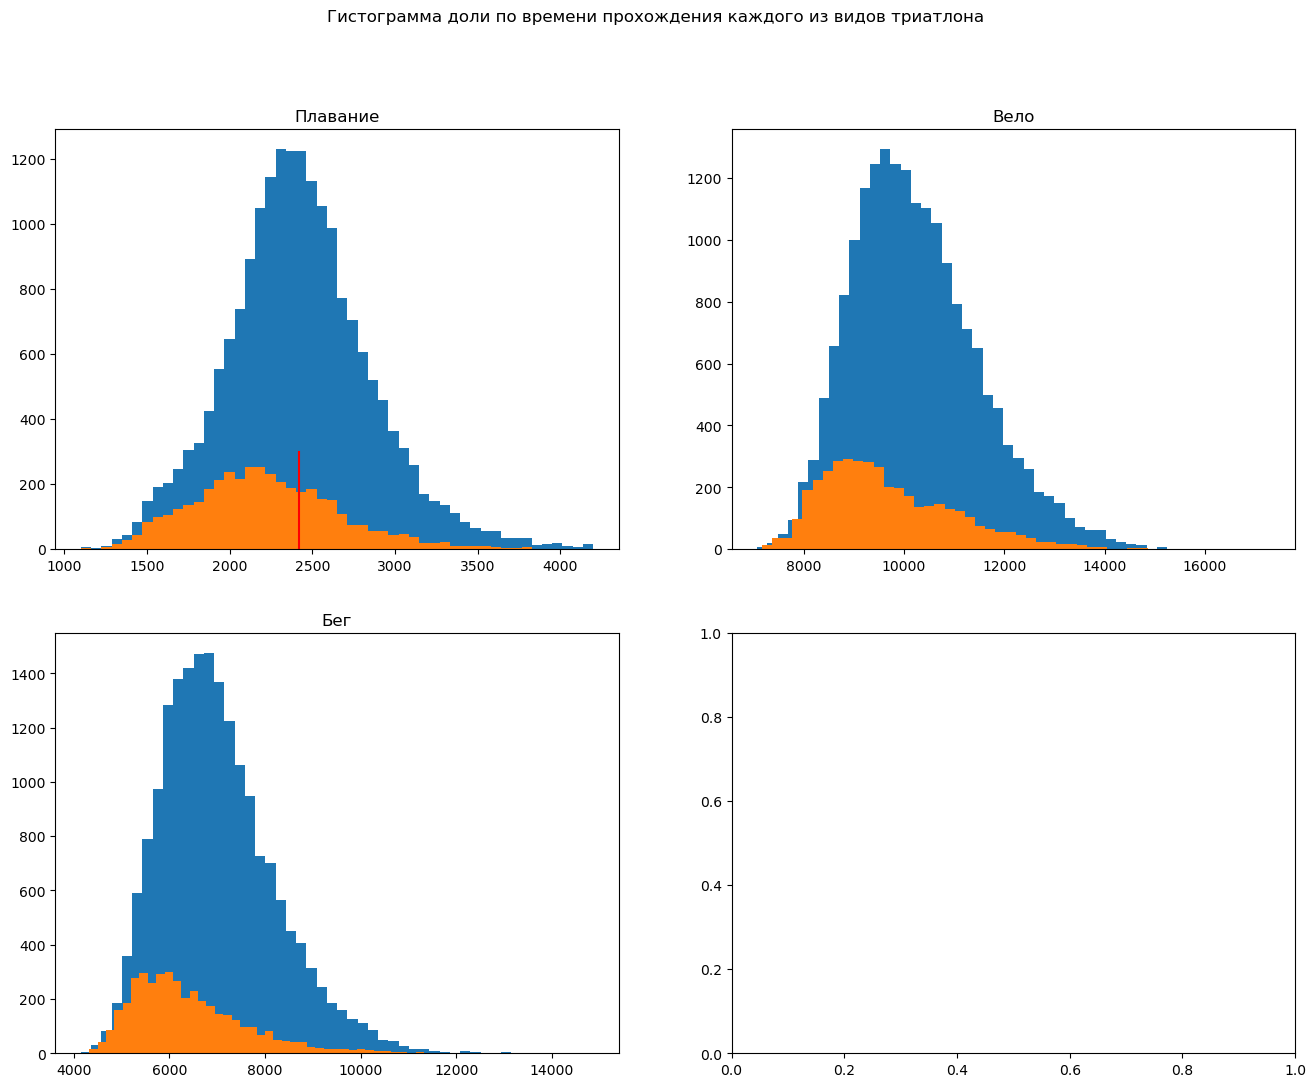

In [48]:
f, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].hist(race.query('cat_place > 0')['swim'], bins=50)
ax[0, 0].hist(race.query('cat_place < 10')['swim'], bins=50)
ax[0, 0].set_title('Плавание')
mm = race.query('cat_place > 0')['swim'].mean()

ax[0, 0].plot([mm, mm] , [0, 300], color = 'red')


ax[0, 1].hist(race.query('cat_place > 0')['bike'], bins=50)
ax[0, 1].hist(race.query('cat_place < 10')['bike'], bins=50)
ax[0, 1].set_title('Вело')

ax[1, 0].hist(race.query('cat_place > 0')['run'], bins=50)
ax[1, 0].hist(race.query('cat_place < 10')['run'], bins=50)
ax[1, 0].set_title('Бег')

#ax[1, 1].hist(dd.query('cat_place > 10')['t_per'], bins=20)
#ax[1, 1].hist(dd.query('cat_place > 10')['t_per'], bins=20)
#ax[1, 1].set_title('Транзитки')


plt.suptitle('Гистограмма доли по времени прохождения каждого из видов триатлона')
plt.show()

In [49]:
race['swim_bin'] = race['swim'] // (1 * 60)
race['bike_bin'] = race['bike'] // (10 * 60)
race['run_bin'] = race['run'] // (10 * 60)
race['t_bin'] = (race['t1'] + race['t2']) // (1 * 60)

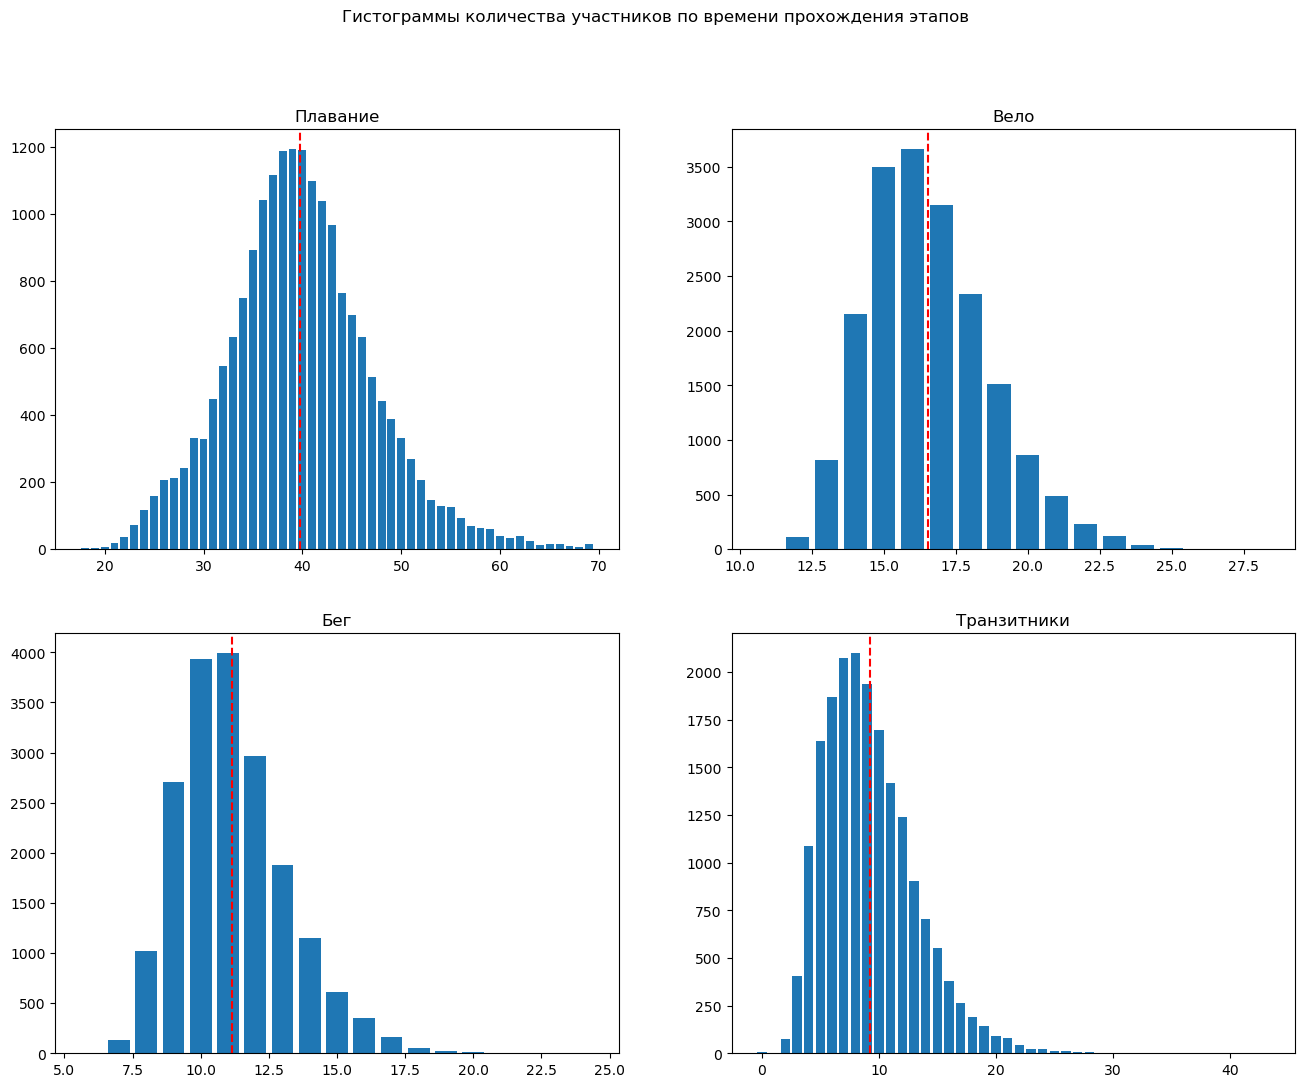

In [50]:
f, ax = plt.subplots(2, 2, figsize=(16, 12))

dd = race.groupby('swim_bin')['number'].count()
ax[0, 0].bar(height = dd.values, x = dd.index)
ax[0, 0].set_title('Плавание')
mm = race['swim_bin'].mean()
ax[0, 0].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')


dd = race.groupby('bike_bin')['number'].count()
ax[0, 1].bar(height = dd.values, x = dd.index)
ax[0, 1].set_title('Вело')
mm = race['bike_bin'].mean()
ax[0, 1].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')

dd = race.groupby('run_bin')['number'].count()
ax[1, 0].bar(height = dd.values, x = dd.index)
ax[1, 0].set_title('Бег')
mm = race['run_bin'].mean()
ax[1, 0].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')

dd = race.groupby('t_bin')['number'].count()
ax[1, 1].bar(height = dd.values, x = dd.index)
ax[1, 1].set_title('Транзитники')
mm = race['t_bin'].mean()
ax[1, 1].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')

plt.suptitle('Гистограммы количества участников по времени прохождения этапов')
plt.show()

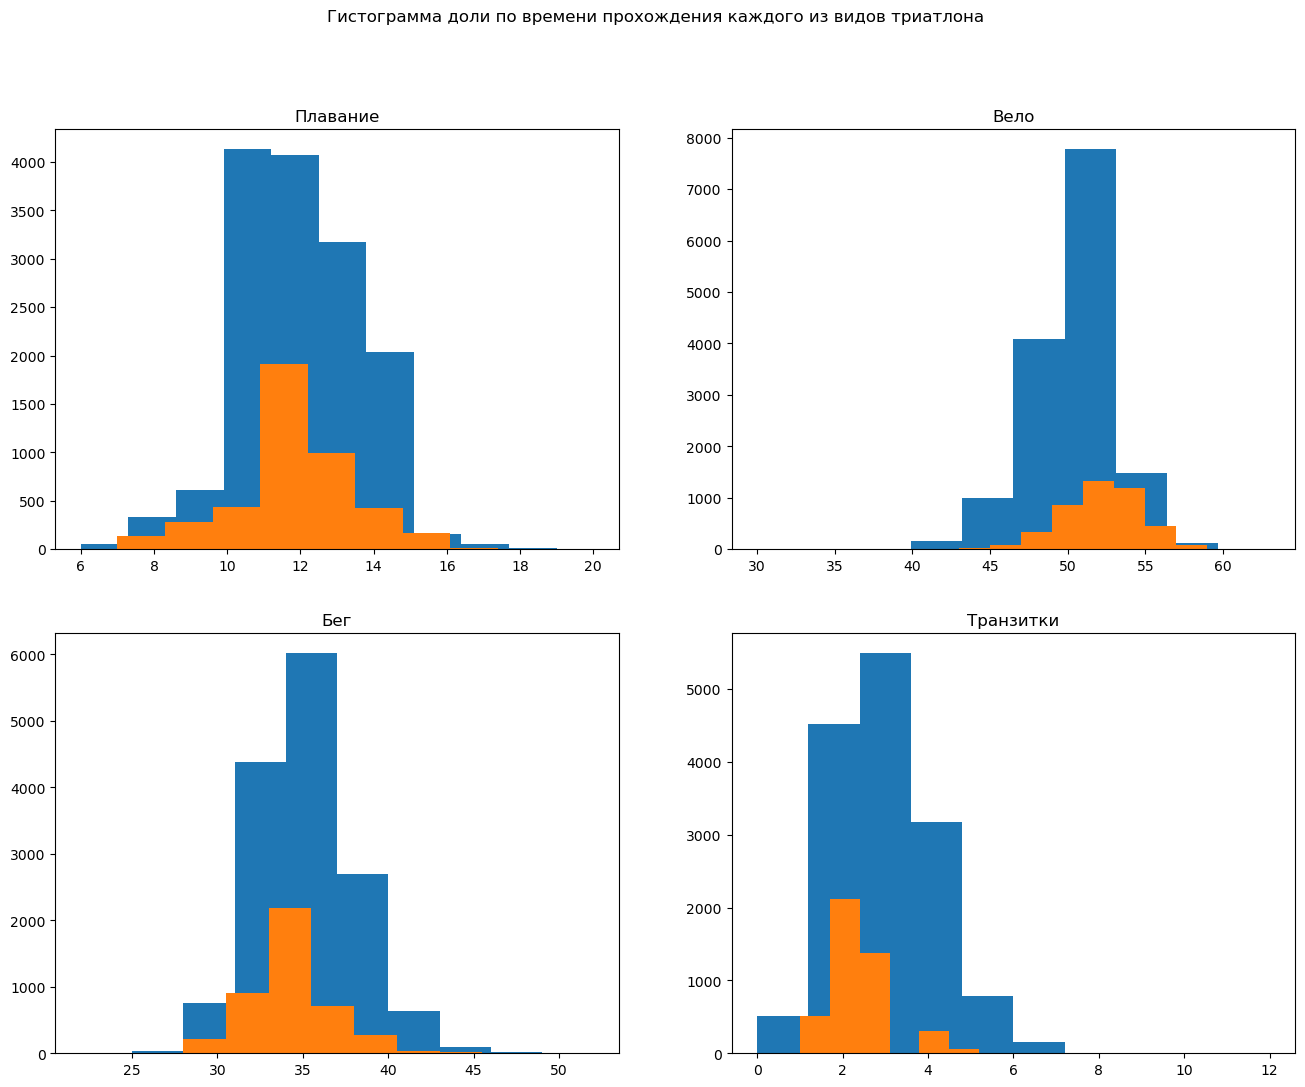

In [51]:
f, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].hist(race.query('cat_place > 10')['swim_per'], bins=10)
ax[0, 0].hist(race.query('cat_place <= 10')['swim_per'], bins=10)
ax[0, 0].set_title('Плавание')

ax[0, 1].hist(race.query('cat_place > 10')['bike_per'], bins=10)
ax[0, 1].hist(race.query('cat_place <= 10')['bike_per'], bins=10)
ax[0, 1].set_title('Вело')

ax[1, 0].hist(race.query('cat_place > 10')['run_per'], bins=10)
ax[1, 0].hist(race.query('cat_place <= 10')['run_per'], bins=10)
ax[1, 0].set_title('Бег')

ax[1, 1].hist(race.query('cat_place > 10')['t_per'], bins=10)
ax[1, 1].hist(race.query('cat_place <= 10')['t_per'], bins=10)
ax[1, 1].set_title('Транзитки')


plt.suptitle('Гистограмма доли по времени прохождения каждого из видов триатлона')
plt.show()

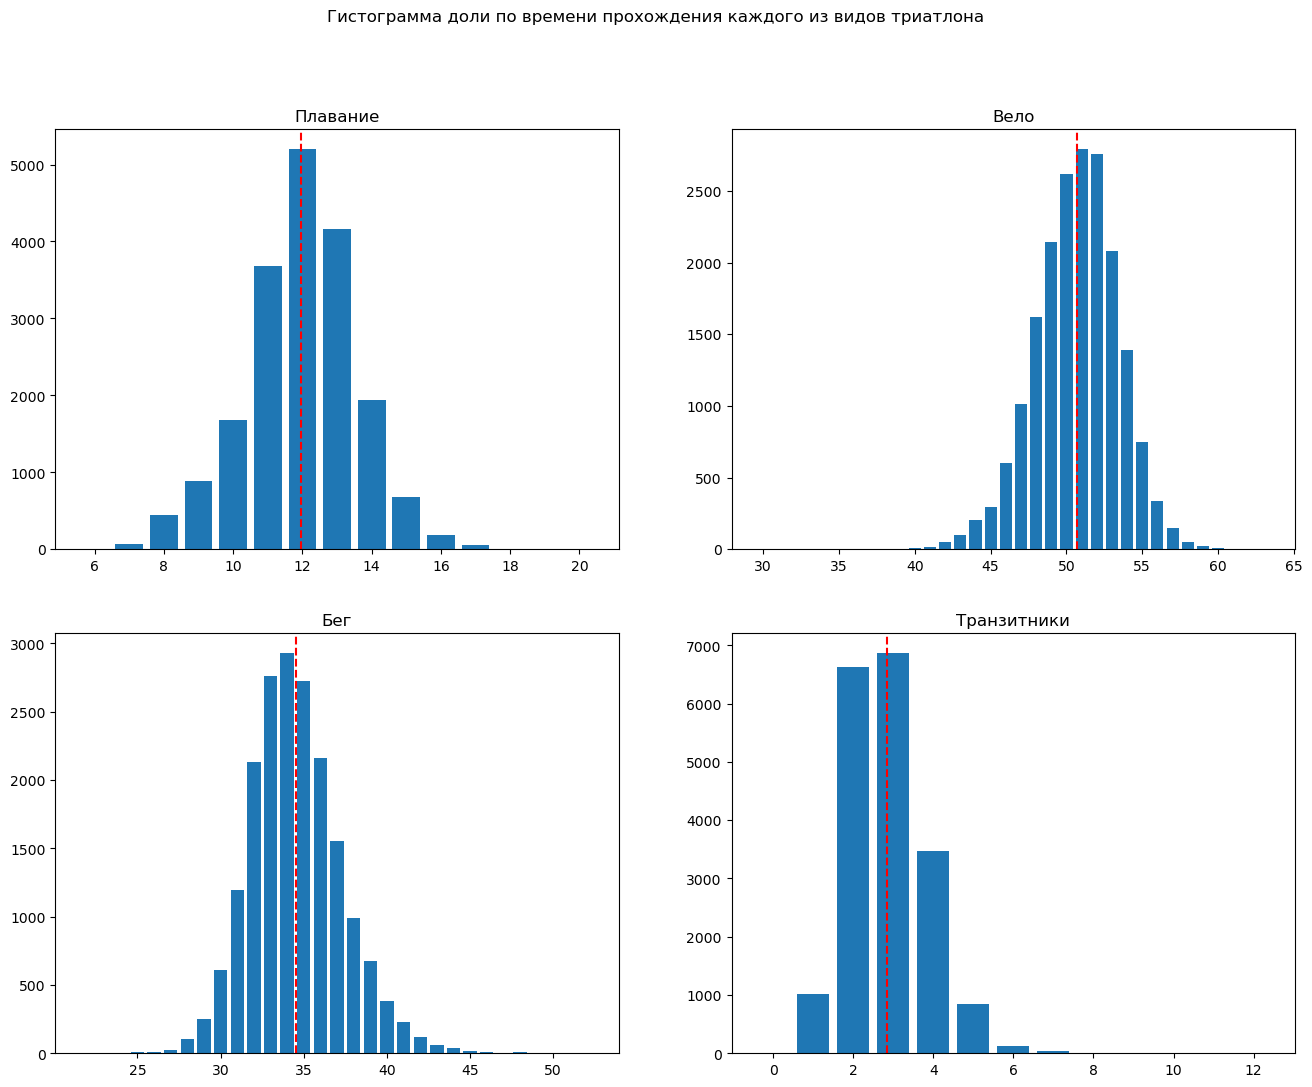

In [52]:
f, ax = plt.subplots(2, 2, figsize=(16, 12))

dd = race.groupby('swim_per')['number'].count()
ax[0, 0].bar(height = dd.values, x = dd.index)
ax[0, 0].set_title('Плавание')
mm = race['swim_per'].mean()
ax[0, 0].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')


dd = race.groupby('bike_per')['number'].count()
ax[0, 1].bar(height = dd.values, x = dd.index)
ax[0, 1].set_title('Вело')
mm = race['bike_per'].mean()
ax[0, 1].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')

dd = race.groupby('run_per')['number'].count()
ax[1, 0].bar(height = dd.values, x = dd.index)
ax[1, 0].set_title('Бег')
mm = race['run_per'].mean()
ax[1, 0].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')

dd = race.groupby('t_per')['number'].count()
ax[1, 1].bar(height = dd.values, x = dd.index)
ax[1, 1].set_title('Транзитники')
mm = race['t_per'].mean()
ax[1, 1].axline(xy1=(mm, 0), xy2=(mm, 50), color='red', linestyle='--')

plt.suptitle('Гистограмма доли по времени прохождения каждого из видов триатлона')
plt.show()

In [53]:
pd.merge(race.query('cat_place > 10')[['swim_per', 'bike_per', 'run_per', 't_per']].describe(), 
         race.query('cat_place <= 10')[['swim_per', 'bike_per', 'run_per', 't_per']].describe(), how='left', 
         left_index=True, right_index=True, suffixes=('_all', '_top10'))

,swim_per_all,bike_per_all,run_per_all,t_per_all,swim_per_top10,bike_per_top10,run_per_top10,t_per_top10
count,14632.000000,14632.000000,14632.000000,14632.000000,4375.000000,4375.000000,4375.000000,4375.000000
mean,11.996788,50.349098,34.670927,2.983598,11.862629,51.736000,34.038171,2.382400
std,1.617409,2.736994,2.822870,1.009492,1.663127,2.576497,2.451385,0.848254
min,6.000000,30.000000,22.000000,0.000000,7.000000,41.000000,23.000000,1.000000
25%,11.000000,49.000000,33.000000,2.000000,11.000000,50.000000,32.000000,2.000000
50%,12.000000,50.000000,34.000000,3.000000,12.000000,52.000000,34.000000,2.000000
75%,13.000000,52.000000,36.000000,4.000000,13.000000,53.000000,35.000000,3.000000
max,19.000000,63.000000,52.000000,12.000000,20.000000,61.000000,48.000000,8.000000


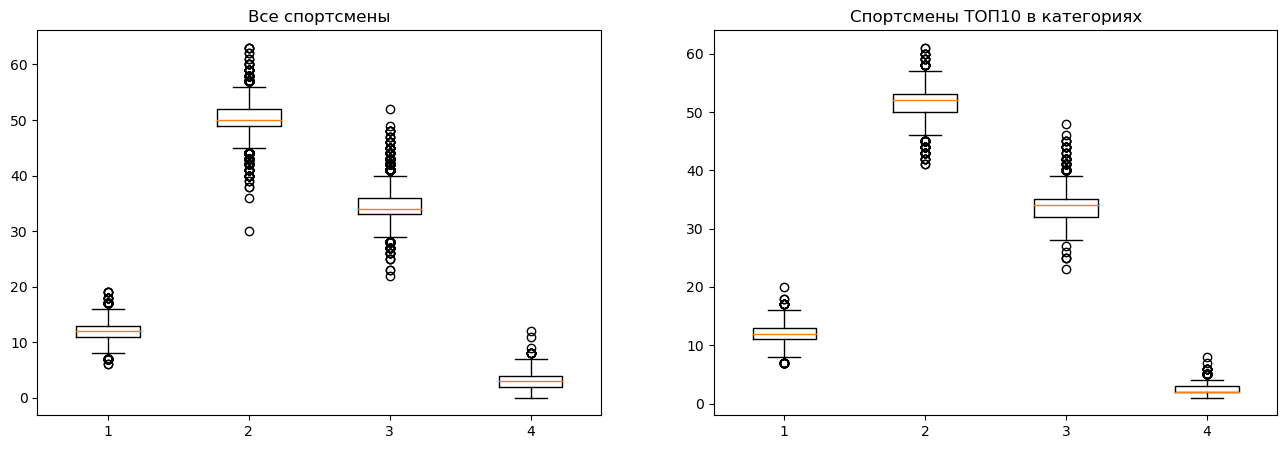

In [54]:
f, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].boxplot(race.query('cat_place > 10')[['swim_per', 'bike_per', 'run_per', 't_per']])
ax[0].set_title('Все спортсмены')

ax[1].boxplot(race.query('cat_place <= 10')[['swim_per', 'bike_per', 'run_per', 't_per']])
ax[1].set_title('Спортсмены ТОП10 в категориях')
plt.show()

In [55]:
pd.merge(race.query('cat_place > 10')[['swim', 'bike', 'run']].describe(), 
         race.query('cat_place <= 10')[['swim', 'bike', 'run']].describe(), how='left', 
         left_index=True, right_index=True, suffixes=('_all', '_top10'))

,swim_all,bike_all,run_all,swim_top10,bike_top10,run_top10
count,14632.000000,14632.000000,14632.000000,4375.000000,4375.000000,4375.000000
mean,2473.833311,10377.576818,7171.298114,2228.514743,9698.726400,6418.270400
std,418.533309,1207.851683,1137.192023,444.294628,1326.217219,1201.805977
min,1140.000000,7071.000000,4264.000000,1101.000000,7163.000000,4148.000000
25%,2212.000000,9494.000000,6350.750000,1924.000000,8712.500000,5539.500000
50%,2444.000000,10217.000000,7000.000000,2194.000000,9426.000000,6164.000000
75%,2713.000000,11098.250000,7810.000000,2498.500000,10523.000000,7052.000000
max,4197.000000,16800.000000,14867.000000,4198.000000,17288.000000,12905.000000


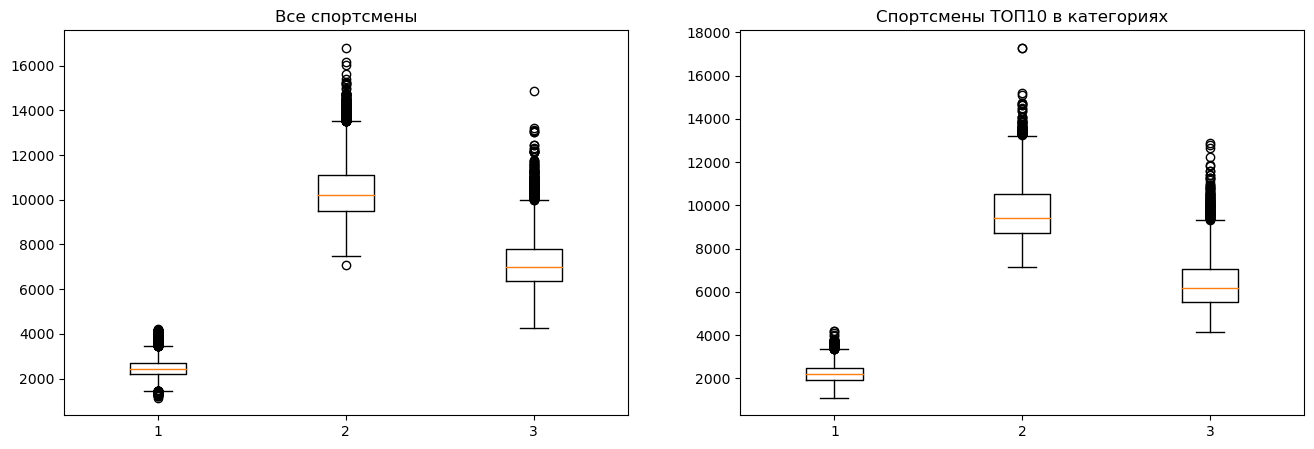

In [56]:
f, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].boxplot(race.query('cat_place > 10')[['swim', 'bike', 'run']])
ax[0].set_title('Все спортсмены')

ax[1].boxplot(race.query('cat_place <= 10')[['swim', 'bike', 'run']])
ax[1].set_title('Спортсмены ТОП10 в категориях')
plt.show()

# Сравнение лучших на отдельных этапах

Участники, вошедшие в 10ку на плавании, веле и беге, какое имеют среднее итоговое время и среднее итоговое место

In [57]:
rawdt['swim_r'] = rawdt.query('status == "OK"').groupby('race')['swim'].rank()
rawdt['bike_r'] = rawdt.query('status == "OK"').groupby('race')['bike'].rank()
rawdt['run_r'] = rawdt.query('status == "OK"').groupby('race')['run'].rank()

In [58]:
top10stage = pd.DataFrame(columns=['dist', 'col', 'res', 'place'])
for dist in ['1/8', 'sprint', '1/4', 'olympic', '113', '226']:
    print(dist)
    for col in ['swim', 'bike', 'run']:
        qq = 'status == "OK" and dist == "' + dist + '" and ' + col + '_r <=10'
        r = int(rawdt.query(qq)['s_finish'].mean())
        p = round(rawdt.query(qq)['place'].mean(), 2)
        print(f'{col} - итоговое время {(r // 3600):02d}:{((r % 3600) // 60):02d}:{(r % 60):02d}, место {p}')
        top10stage.loc[len(top10stage)] = [dist, col, r, p]

1/8
swim - итоговое время 01:06:15, место 33.05
bike - итоговое время 01:02:25, место 10.0
run - итоговое время 01:03:03, место 14.62
sprint
swim - итоговое время 01:11:15, место 17.33
bike - итоговое время 01:09:03, место 9.34
run - итоговое время 01:09:48, место 10.82
1/4
swim - итоговое время 02:14:01, место 34.34
bike - итоговое время 02:08:32, место 13.72
run - итоговое время 02:08:58, место 13.94
olympic
swim - итоговое время 02:17:23, место 31.31
bike - итоговое время 02:11:16, место 11.49
run - итоговое время 02:12:11, место 14.45
113
swim - итоговое время 04:31:45, место 38.48
bike - итоговое время 04:19:02, место 10.95
run - итоговое время 04:18:47, место 10.28
226
swim - итоговое время 09:49:50, место 43.97
bike - итоговое время 09:18:03, место 13.21
run - итоговое время 09:16:28, место 15.64


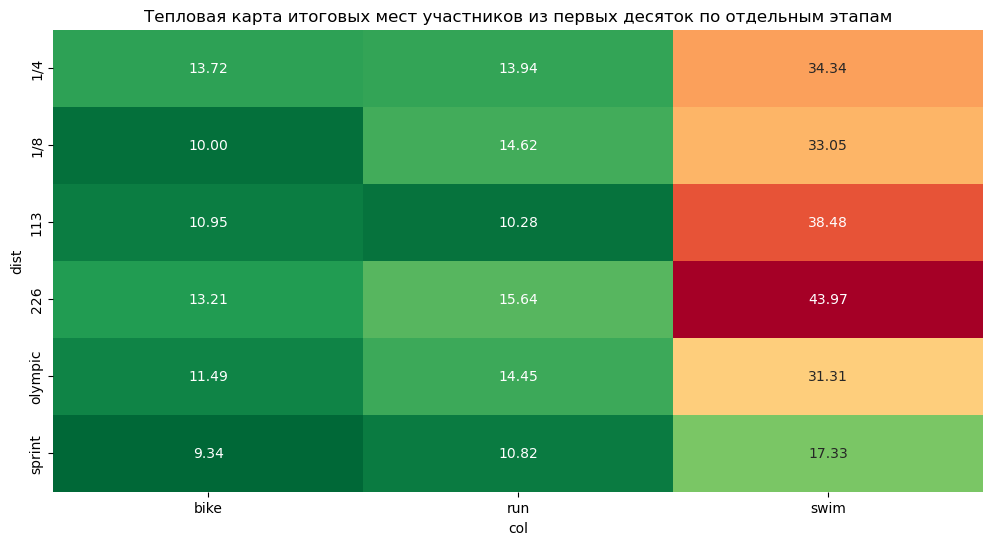

In [59]:
fig = plt.figure(figsize = (12, 6))
dd = top10stage.pivot(index='dist', columns = 'col', values = 'place')
sns.heatmap(dd, cmap='RdYlGn_r', annot=True, cbar=False, fmt='.2f')
plt.title(f'Тепловая карта итоговых мест участников из первых десяток по отдельным этапам')
plt.show()

In [60]:
dd = top10stage.pivot(index='dist', columns = 'col', values = 'res')
for col in dd.columns:
    dd[col] = dd[col].apply(lambda x: f'{(x // 3600):02d}:{((x % 3600) // 60):02d}:{(x % 60):02d}')
dd

col,bike,run,swim
dist,,,
1/4,02:08:32,02:08:58,02:14:01
1/8,01:02:25,01:03:03,01:06:15
113,04:19:02,04:18:47,04:31:45
226,09:18:03,09:16:28,09:49:50
olympic,02:11:16,02:12:11,02:17:23
sprint,01:09:03,01:09:48,01:11:15


Итоговые места выше у лучших велосипедистов и бегунов, а лучшие пловцы заметно проваливаются в итоге =)